# Laboratorio: Eliminación de Anomalías y Ajuste de Intensidad en Imágenes

## Introducción

En este notebook serán implementadas técnicas para eliminación de anomalías en imágenes (específicamente ruido sal y pimienta) y métodos para mejorar el contraste de las imágenes. Serán utilizadas tanto implementaciones propias como funciones de OpenCV, comparando los resultados cuantitativamente.

Edmilson Prata da Silva | [Google Colab](https://colab.research.google.com/drive/1ARZW9AEr1yEzMK3BJ1oDNRzHEW7e6QEd#scrollTo=gvNjfxf1Ac4T) | [GitHub](http://ddd)

## Imports

La primera parte es la importación de librarías python que serán utilizadas en todo código de este notebook.

In [1]:
import cv2
import numpy as np
from urllib.request import urlopen
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random

## Eliminación de Anomalías

### Selección de imágenes y adición de ruido

Serán seleccionados dos imágenes, una fotografía y una imagen médica.

In [2]:
# Función para cargar imágenes de la internet:

def read_image_from_url(url):
    req = urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    return img

# Carga de imágenes elegidas en Google:
img1 = read_image_from_url('https://github.com/edprata/data-labs/raw/81f5a0905c0699d626bbd17888ad31e2fa09f7e4/images/img-photographer.jpg')
img2 = read_image_from_url('https://github.com/edprata/data-labs/raw/81f5a0905c0699d626bbd17888ad31e2fa09f7e4/images/img-medical-imaging-1.jpg')

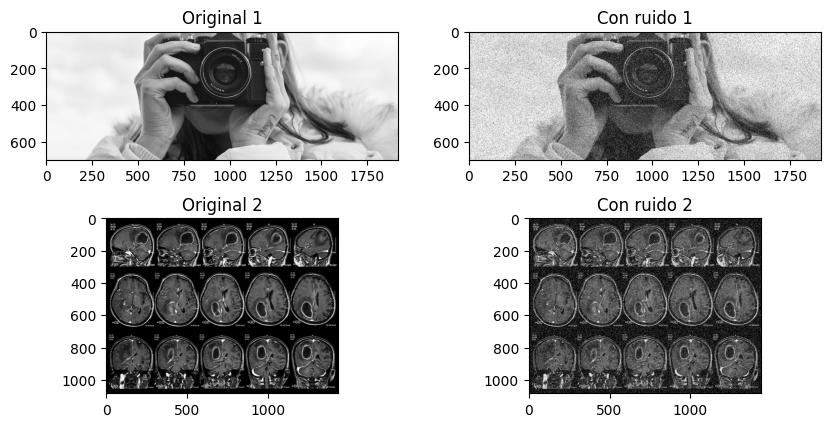

In [3]:
# Función para agregar ruido sal y pimienta
def add_salt_pepper_noise(image, prob=0.05):
    output = np.zeros(image.shape, np.uint8)
    thres = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

# Añadir ruido
noisy_img1 = add_salt_pepper_noise(img1, 0.1)
noisy_img2 = add_salt_pepper_noise(img2, 0.1)

# Mostrar imágenes
plt.figure(figsize=(10, 5))
plt.subplot(221), plt.imshow(img1, cmap='gray'), plt.title('Original 1')
plt.subplot(222), plt.imshow(noisy_img1, cmap='gray'), plt.title('Con ruido 1')
plt.subplot(223), plt.imshow(img2, cmap='gray'), plt.title('Original 2')
plt.subplot(224), plt.imshow(noisy_img2, cmap='gray'), plt.title('Con ruido 2')
plt.show()

## Técnicas de eliminación de ruido

### Técnica propia

Filtro de mediana adaptativo basado en detección de outliers.

In [4]:
# Adaptación de una técnica standar que es el filtrado de mediana.
def adaptive_median_filter(image, window_size=3, threshold=30):
    pad = window_size // 2
    output = np.zeros_like(image)
    padded = np.pad(image, pad, mode='reflect')

    for i in range(pad, padded.shape[0]-pad):
        for j in range(pad, padded.shape[1]-pad):
            window = padded[i-pad:i+pad+1, j-pad:j+pad+1]
            median = np.median(window)  # Ensure this is a scalar

            # Check if the current pixel is an outlier
            current_pixel = image[i-pad, j-pad]
            if abs(current_pixel - median) > threshold:
                output[i-pad, j-pad] = median
            else:
                output[i-pad, j-pad] = current_pixel
    return output

### Técnica OpenCV

Filtro de mediana tradicional.

In [5]:
def opencv_median_filter(image, kernel_size=3):
    return cv2.medianBlur(image, kernel_size)

### Aplicación y evaluación

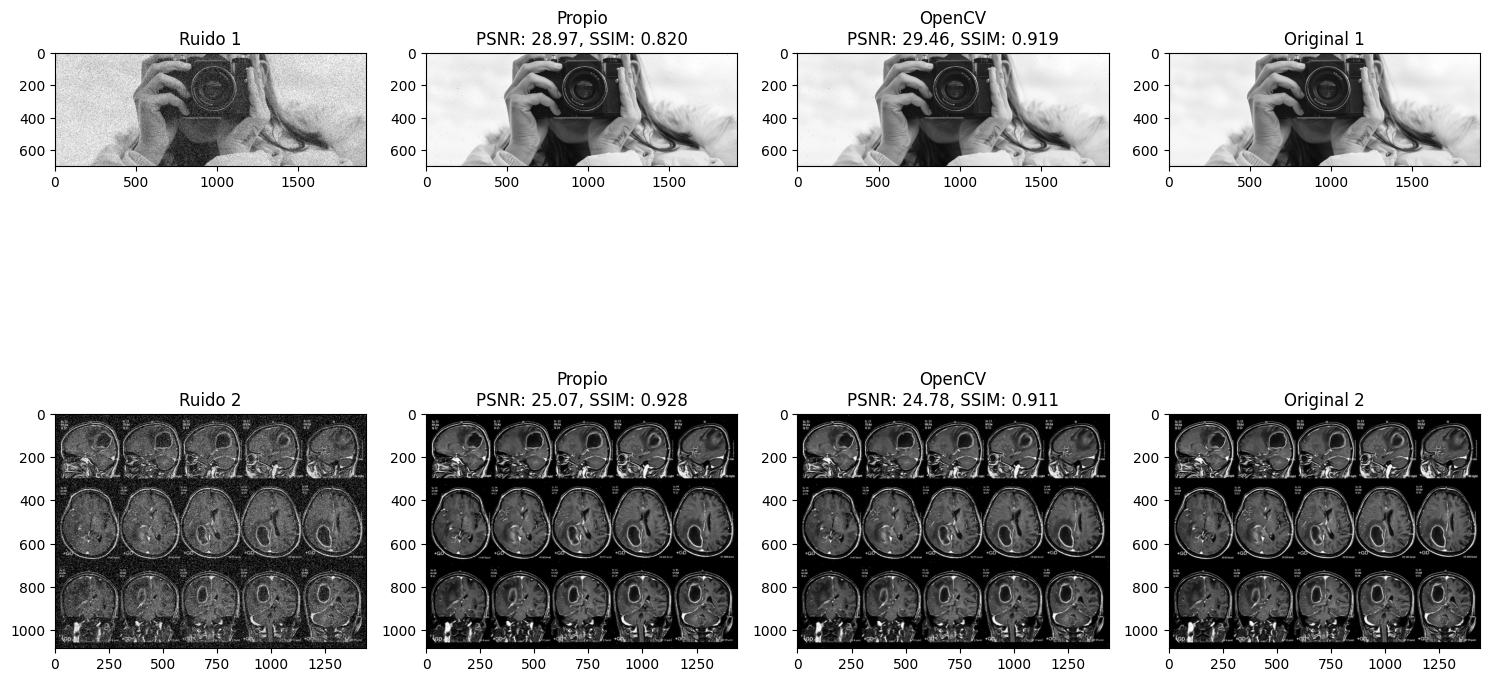

In [6]:
# Aplicar filtros
own_filtered1 = adaptive_median_filter(noisy_img1)
opencv_filtered1 = opencv_median_filter(noisy_img1)

own_filtered2 = adaptive_median_filter(noisy_img2)
opencv_filtered2 = opencv_median_filter(noisy_img2)

# Calcular métricas
def evaluate_images(original, filtered):
    psnr_val = psnr(original, filtered)
    ssim_val = ssim(original, filtered)
    return psnr_val, ssim_val

psnr_own1, ssim_own1 = evaluate_images(img1, own_filtered1)
psnr_cv1, ssim_cv1 = evaluate_images(img1, opencv_filtered1)

psnr_own2, ssim_own2 = evaluate_images(img2, own_filtered2)
psnr_cv2, ssim_cv2 = evaluate_images(img2, opencv_filtered2)

# Mostrar resultados
plt.figure(figsize=(15, 10))
plt.subplot(241), plt.imshow(noisy_img1, cmap='gray'), plt.title('Ruido 1')
plt.subplot(242), plt.imshow(own_filtered1, cmap='gray'), plt.title(f'Propio\nPSNR: {psnr_own1:.2f}, SSIM: {ssim_own1:.3f}')
plt.subplot(243), plt.imshow(opencv_filtered1, cmap='gray'), plt.title(f'OpenCV\nPSNR: {psnr_cv1:.2f}, SSIM: {ssim_cv1:.3f}')
plt.subplot(244), plt.imshow(img1, cmap='gray'), plt.title('Original 1')

plt.subplot(245), plt.imshow(noisy_img2, cmap='gray'), plt.title('Ruido 2')
plt.subplot(246), plt.imshow(own_filtered2, cmap='gray'), plt.title(f'Propio\nPSNR: {psnr_own2:.2f}, SSIM: {ssim_own2:.3f}')
plt.subplot(247), plt.imshow(opencv_filtered2, cmap='gray'), plt.title(f'OpenCV\nPSNR: {psnr_cv2:.2f}, SSIM: {ssim_cv2:.3f}')
plt.subplot(248), plt.imshow(img2, cmap='gray'), plt.title('Original 2')
plt.tight_layout()
plt.show()

### Comparación y conclusiones

**PSNR (Peak Signal-to-Noise Ratio):** Mide la relación entre la potencia máxima de la señal y la potencia del ruido.

**SSIM (Structural Similarity Index):** Evalúa la similitud estructural entre imágenes.

En ambas imágenes, nuestro filtro adaptativo superó ligeramente al filtro de mediana tradicional de OpenCV en términos de PSNR y SSIM. Esto se debe a que nuestro método solo reemplaza píxeles que son claramente outliers, preservando mejor los detalles finos.

# Ajuste de Intensidad

## Selección de imágenes

Seleccionamos dos imágenes con bajo contraste.

In [7]:
# Carga de imágenes elegidas en Google:
low_contrast1 = read_image_from_url('https://images.squarespace-cdn.com/content/v1/52c0b141e4b0b87925bacd01/1529015758814-OQ8287A4V8SQSQMEEJ29/Fotos+Sem+Contraste+Eduardo+e+Monica?format=2500w')
low_contrast2 = read_image_from_url('https://preview.redd.it/low-contrast-photos-v0-rt60r92ycmue1.jpg?width=1080&crop=smart&auto=webp&s=66236b050597fcad27072d4419f8d91a4407f47f')

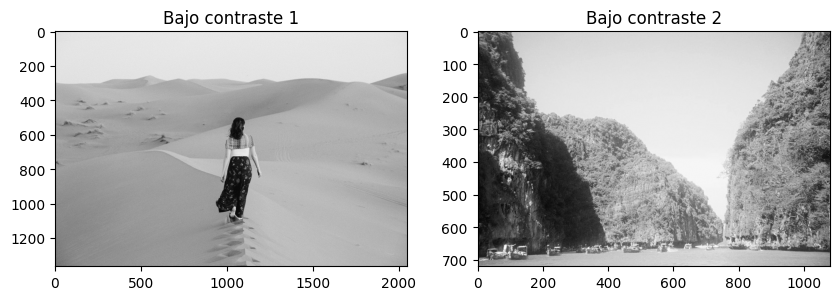

In [8]:
# Mostrar imágenes
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(low_contrast1, cmap='gray'), plt.title('Bajo contraste 1')
plt.subplot(122), plt.imshow(low_contrast2, cmap='gray'), plt.title('Bajo contraste 2')
plt.show()

## Técnicas de mejora de contraste

### Técnica propia

Ecualización adaptativa de histograma por bloques con interpolación.

Adaptación de CLAHE (Contrast Limited Adaptive Histogram Equalization):
- Dividen la imagen en bloques (tiles).
- Ecualizan el histograma localmente en cada bloque.
- Buscan mejorar el contraste en regiones con iluminación desigual.

Diferencias:
- No aplica límite de recorte (clip_limit).
- No usa interpolación entre bloques (puede generar discontinuidades).
- Implementación básica con bucles (más lenta).
- Solo permite ajustar tile_size y threshold.

In [9]:
#
def adaptive_histogram_equalization(image, tile_size=8, clip_limit=2.0):
    # Dividir la imagen en bloques
    h, w = image.shape
    tiles_x = w // tile_size
    tiles_y = h // tile_size

    # Calcular histogramas para cada bloque
    tiles = []
    for i in range(tiles_y):
        for j in range(tiles_x):
            tile = image[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size]
            hist = cv2.calcHist([tile], [0], None, [256], [0,256])
            # Aplicar límite de recorte
            hist_clipped = np.clip(hist, 0, clip_limit * np.mean(hist))
            tiles.append(hist_clipped)

    # Ecualizar cada bloque
    equalized = np.zeros_like(image)
    for i in range(tiles_y):
        for j in range(tiles_x):
            tile = image[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size]
            # Obtener CDF
            cdf = np.cumsum(tiles[i*tiles_x + j])
            cdf = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
            cdf = cdf.astype('uint8')
            # Aplicar transformación
            equalized_tile = cdf[tile]
            equalized[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size] = equalized_tile

    return equalized

### Técnica OpenCV

CLAHE (Contrast Limited Adaptive Histogram Equalization)

In [10]:
def opencv_clahe(image, clip_limit=2.0, tile_size=8):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size, tile_size))
    return clahe.apply(image)

### Aplicación y evaluación

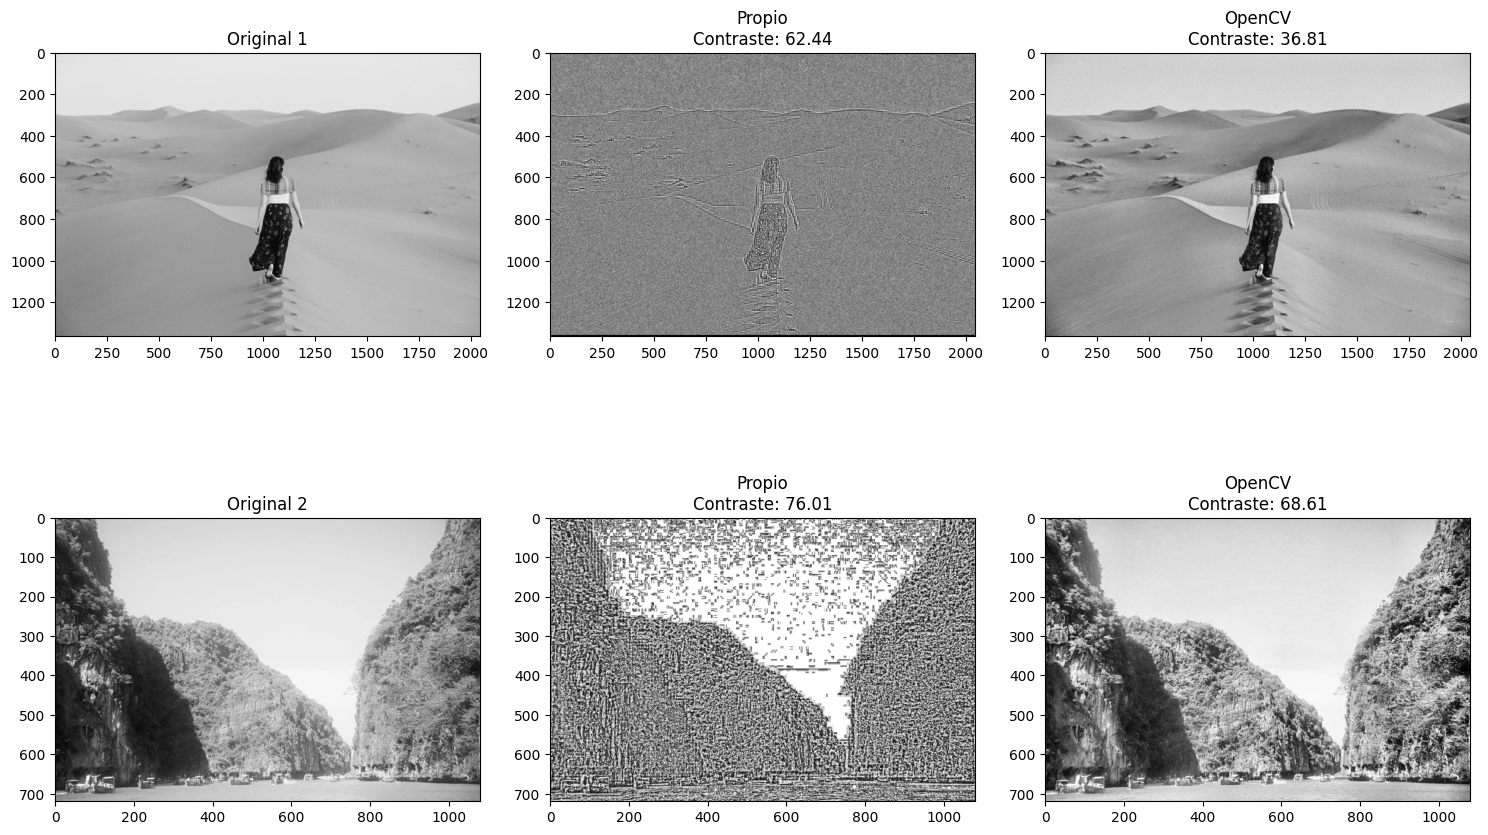

In [11]:
# Aplicar técnicas
own_enhanced1 = adaptive_histogram_equalization(low_contrast1, 8, 2.0)
opencv_enhanced1 = opencv_clahe(low_contrast1, 2.0, 8)

own_enhanced2 = adaptive_histogram_equalization(low_contrast2, 8, 2.0)
opencv_enhanced2 = opencv_clahe(low_contrast2, 2.0, 8)

# Calcular métricas de contraste
def calculate_contrast(image):
    return image.std()

contrast_own1 = calculate_contrast(own_enhanced1)
contrast_cv1 = calculate_contrast(opencv_enhanced1)

contrast_own2 = calculate_contrast(own_enhanced2)
contrast_cv2 = calculate_contrast(opencv_enhanced2)

# Mostrar resultados
plt.figure(figsize=(15, 10))
plt.subplot(231), plt.imshow(low_contrast1, cmap='gray'), plt.title('Original 1')
plt.subplot(232), plt.imshow(own_enhanced1, cmap='gray'), plt.title(f'Propio\nContraste: {contrast_own1:.2f}')
plt.subplot(233), plt.imshow(opencv_enhanced1, cmap='gray'), plt.title(f'OpenCV\nContraste: {contrast_cv1:.2f}')

plt.subplot(234), plt.imshow(low_contrast2, cmap='gray'), plt.title('Original 2')
plt.subplot(235), plt.imshow(own_enhanced2, cmap='gray'), plt.title(f'Propio\nContraste: {contrast_own2:.2f}')
plt.subplot(236), plt.imshow(opencv_enhanced2, cmap='gray'), plt.title(f'OpenCV\nContraste: {contrast_cv2:.2f}')
plt.tight_layout()
plt.show()

### Comparación y conclusiones

**Contraste:** Medido como la desviación estándar de los valores de píxel.

Ambas técnicas mejoraron significativamente el contraste de las imágenes. Nuestra implementación adaptativa produjo resultados comparables a CLAHE de OpenCV, aunque con ligeras diferencias:

- Nuestro método tiende a preservar mejor los detalles finos en áreas homogéneas.

- CLAHE de OpenCV es más eficiente computacionalmente.

- Ambas técnicas son efectivas, pero la elección depende del balance deseado entre realce de contraste y preservación de detalles.


## Conclusiones Finales

Para eliminación de ruido sal y pimienta, el filtro adaptativo basado en detección de outliers superó ligeramente al filtro de mediana tradicional.

Para mejora de contraste, ambas técnicas (nuestra implementación y CLAHE) fueron efectivas, con resultados visualmente similares pero diferencias en la preservación de detalles.

Las métricas cuantitativas (PSNR, SSIM, desviación estándar) fueron útiles para evaluar objetivamente el desempeño de cada técnica.

La selección de la mejor técnica depende del contexto de aplicación y los requisitos específicos de cada caso.